# Roadshow CreditCard Default Classifcation Demo

## CRISP-DM Data Science Process

* Business understanding (20% time)
* Data Understanding (20% time)
* Data Preparation (20% time)
* Modeling (25% time)
* Evaluation (15% time)

<img src='CRISP-DM_Process_Diagram.png' width="600">

# CRISP-DM -- Business Understanding - 20% Time
* Determine Business goal or problem.
    * Who are the important stakeholders?
    * Make a clear and concise description of the business goal.
    * Which business metrics can we use to measure the costs or benefits of a chosen business solution?
* Translate business goal to Data Science goal using Ideation or Design Thinking for Data Science:
    * What Data Science models are most suited to solve this problem?
    * What data do we need to create a model?
    * Which Data Science models are most feasible to create given the data we have?
    * How do we measure fit of the Data Science model with respect to chosen business metric?
 

Finally see interactive discussion with Cyriel 😀

# CRISP-DM -- Data Understanding & Preparation - 40% Time

## Python Library Imports

In [145]:
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scikitplot as skplt
from scipy.stats import norm
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.mixture import GaussianMixture, GMM
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.optimize import curve_fit
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score

import sklearn.linear_model as skl_lm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn import neighbors
from IPython.display import display_html

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-ticks')

## Load CreditCard Default Data

In [146]:
cc_data = pd.read_csv('Default.csv', index_col=0, sep=';')

In [147]:
cc_data.shape

(10000, 4)

In [148]:
cc_data.head()

,default,student,balance,income
1,No,No,"729,5264952","44361,62507"
2,No,Yes,"817,1804066","12106,1347"
3,No,No,"1073,549164","31767,13895"
4,No,No,"529,2506047","35704,49394"
5,No,No,"785,6558829","38463,49588"


### Transform Data

In [149]:
cc_data.dtypes

default    object
student    object
balance    object
income     object
dtype: object

In [150]:
#Convert to correct types
cc_data['default'] = cc_data['default'].astype('category')
cc_data['student'] = cc_data['student'].astype('category')
cc_data['balance'] = cc_data['balance'].apply(lambda str_flt : float(str_flt.replace(',','.'))).astype('float')
cc_data['income'] = cc_data['income'].apply(lambda str_flt : float(str_flt.replace(',','.'))).astype('float')
cc_data['default_encoded'] = cc_data.default.factorize()[0]
cc_data['student_encoded'] = cc_data.student.factorize()[0]

#Scales variables for Machine learning models
scaler = MinMaxScaler()
scaler.fit(cc_data[['balance']])
cc_data['balance_scaled'] = scaler.transform(cc_data[['balance']])
scaler.fit(cc_data[['income']])
cc_data['income_scaled'] = scaler.transform(cc_data[['income']])
cc_data = cc_data.sort_index(axis=1)

cc_data.dtypes

balance             float64
balance_scaled      float64
default            category
default_encoded       int64
income              float64
income_scaled       float64
student            category
student_encoded       int64
dtype: object

In [65]:
cc_data.head()

,balance,balance_scaled,default,default_encoded,income,income_scaled,student,student_encoded
1,729.526495,0.274845,No,0,44361.62507,0.598905,No,0
2,817.180407,0.307868,No,0,12106.13470,0.155727,Yes,1
3,1073.549164,0.404453,No,0,31767.13895,0.425862,No,0
4,529.250605,0.199392,No,0,35704.49394,0.479959,No,0
5,785.655883,0.295991,No,0,38463.49588,0.517867,No,0


### Descriptive Statistics

In [66]:
cc_data.loc[:,['balance', 'balance_scaled', 'income', 'income_scaled']].describe()

,balance,balance_scaled,income,income_scaled
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,835.374886,0.314722,33516.981876,0.449904
std,483.714985,0.182237,13336.639563,0.183240
min,0.000000,0.000000,771.967729,0.000000
25%,481.731105,0.181489,21340.462905,0.282603
50%,823.636973,0.310300,34552.644800,0.464133
75%,1166.308387,0.439400,43807.729275,0.591295
max,2654.322576,1.000000,73554.233500,1.000000


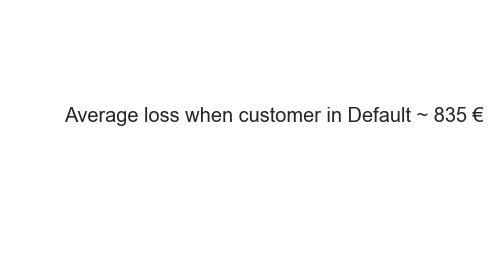

In [152]:
t_ax = plt.text(0.1,0.5, 'Average loss when customer in Default ~ {} €'.format(835),size=20)
t_ax = plt.axis('off')

### Check Duplicates

In [68]:
dups = cc_data.duplicated(subset=['default','student','balance','income']).sum()
print('Aantal duplicaten: {}'.format(dups))

Aantal duplicaten: 0


### Check NaNs

In [69]:
cc_data.isnull().sum()

balance            0
balance_scaled     0
default            0
default_encoded    0
income             0
income_scaled      0
student            0
student_encoded    0
dtype: int64

## Explore CreditCard Default Data

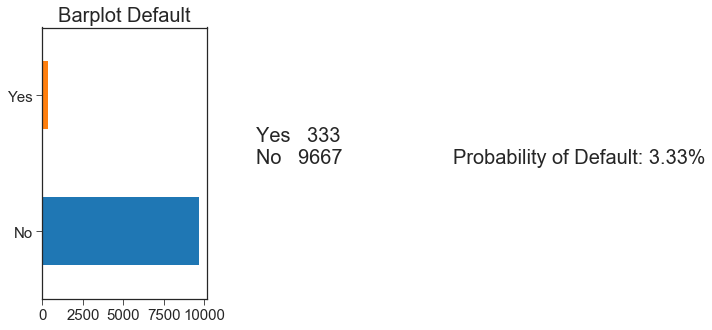

In [70]:
fig, axes = plt.subplots(1,3,figsize=(10,5))
d_ax = cc_data.default.value_counts().plot.barh(fontsize=15, title='Barplot Default', ax=axes[0])
axes[0].title.set_size(20)

t_tbl = cc_data.default.value_counts().to_frame().sort_index(ascending=False)
t_ax = axes[1].text(0.1,0.5,t_tbl.to_string(header=False),size=20)
t_ax = axes[1].axis('off')
t_ax = axes[2].text(0.1,0.5, 'Probability of Default: {}%'.format(round(333/(333+9667)*100,2)),size=20)
t_ax = axes[2].axis('off')

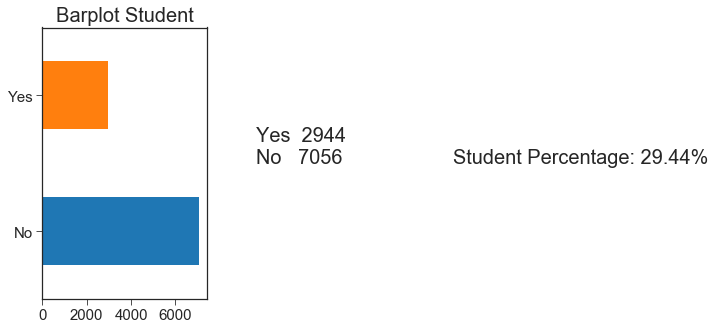

In [155]:
fig, axes = plt.subplots(1,3,figsize=(10,5))
d_ax = cc_data.student.value_counts().plot.barh(fontsize=15, title='Barplot Student', ax=axes[0])
axes[0].title.set_size(20)

t_tbl = cc_data.student.value_counts().to_frame().sort_index(ascending=False)
t_ax = axes[1].text(0.1,0.5,t_tbl.to_string(header=False),size=20)
t_ax = axes[1].axis('off')
t_ax = axes[2].text(0.1,0.5, 'Student Percentage: {}%'.format(round(2944/(2944+7056)*100,2)),size=20)
t_ax = axes[2].axis('off')

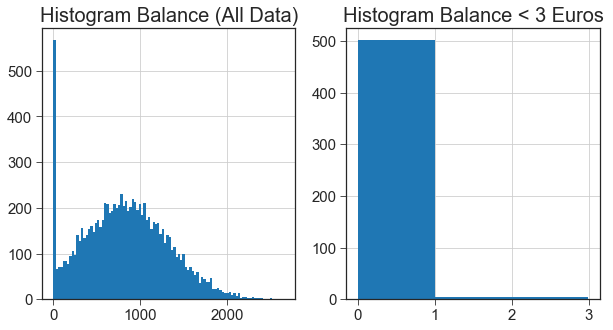

In [72]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax0 = cc_data.balance.hist(bins=100, ax=axes[0])
ax0.set_title('Histogram Balance (All Data)')
ax0.title.set_size(20)
ax0.tick_params(labelsize=15)
ax1 = cc_data.loc[cc_data.balance < 3, :].balance.hist(bins=3, ax=axes[1])
ax1.set_title('Histogram Balance < 3 Euros')
ax1.title.set_size(20)
ax1.tick_params(labelsize=15)

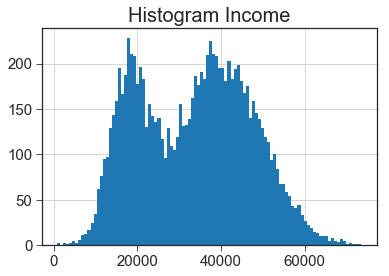

In [73]:
i_ax = cc_data.income.hist(bins=100)
i_ax.set_title('Histogram Income')
i_ax.title.set_size(20)
i_ax.tick_params(labelsize=15)

#### Explore Balance

In [74]:
print('\t Absolut Aantal Individuen < 1 euro op balance: {}\n'.format(cc_data.loc[cc_data.balance < 1, :].shape[0])
      ,'\t Percentage Aantal Individuen < 1 euro op balance: {}%'.format(cc_data.loc[cc_data.balance < 1, :].shape[0] / cc_data.shape[0] * 100))

	 Absolut Aantal Individuen < 1 euro op balance: 501
 	 Percentage Aantal Individuen < 1 euro op balance: 5.01%


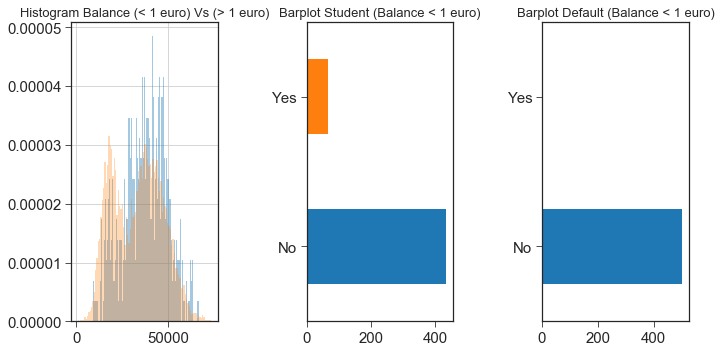

In [75]:
fig, axes = plt.subplots(1,3,figsize=(10,5))
cc_data.loc[cc_data.balance < 1, :].income.hist(bins=100, ax=axes[0], alpha=0.4, density=True)
cc_data.loc[cc_data.balance > 1, :].income.hist(bins=100, ax=axes[0], alpha=0.3, density=True)
axes[0].set_title('Histogram Income (< 1 euro) Vs (> 1 euro)')
axes[0].title.set_size(13)
axes[0].tick_params(labelsize=15)
cc_data.loc[cc_data.balance < 1, :].student.value_counts().plot.barh(fontsize=15, title='Barplot Student (Balance < 1 euro)', ax=axes[1])
axes[1].title.set_size(13)
cc_data.loc[cc_data.balance < 1, :].default.value_counts().plot.barh(fontsize=15, title='Barplot Default (Balance < 1 euro)', ax=axes[2])
axes[2].title.set_size(13)
plt.tight_layout()

In [76]:
#Create variable less than 1 < euro (binary categorical)
cc_data['balance_lt_1_eur'] = np.NaN
cc_data.loc[cc_data.balance < 1,'balance_lt_1_eur'] = 1
cc_data.loc[cc_data.balance > 1,'balance_lt_1_eur'] = 0
cc_data['balance_lt_1_eur'] = cc_data['balance_lt_1_eur'].astype('int')
cc_data = cc_data.sort_index(axis=1)
cc_data.head()

,balance,balance_lt_1_eur,balance_scaled,default,default_encoded,income,income_scaled,student,student_encoded
1,729.526495,0,0.274845,No,0,44361.62507,0.598905,No,0
2,817.180407,0,0.307868,No,0,12106.13470,0.155727,Yes,1
3,1073.549164,0,0.404453,No,0,31767.13895,0.425862,No,0
4,529.250605,0,0.199392,No,0,35704.49394,0.479959,No,0
5,785.655883,0,0.295991,No,0,38463.49588,0.517867,No,0


### Explore Income (TODO Delete)

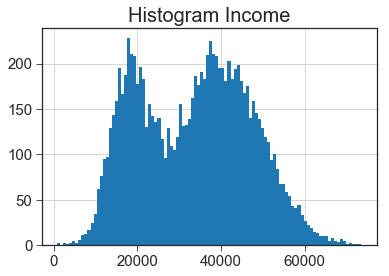

In [77]:
i_ax = cc_data.income.hist(bins=100)
i_ax.set_title('Histogram Income')
i_ax.title.set_size(20)
i_ax.tick_params(labelsize=15)

In [78]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

g1 = cc_data[cc_data.income < 26000].default.value_counts().rename('Income Group1').to_frame()
g1.index = g1.index.astype('object')
g1.at['Default %','Income Group1'] = 139/(3275+139) * 100
g1.at['No Default %','Income Group1'] = 3275/(3275+139) * 100
g2 = cc_data[cc_data.income >= 26000].default.value_counts().rename('Income Group2').to_frame()
g2.index = g2.index.astype('object')
g2.at['Default %','Income Group2'] = 194/(6392+194) * 100
g2.at['No Default %','Income Group2'] = 6392/(6392+194) * 100

display_side_by_side(g1, g2)

,Income Group1
No,3275.00000
Yes,139.00000
Default %,4.07147
No Default %,95.92853
,Income Group2
No,6392.000000
Yes,194.000000
Default %,2.945642
No Default %,97.054358


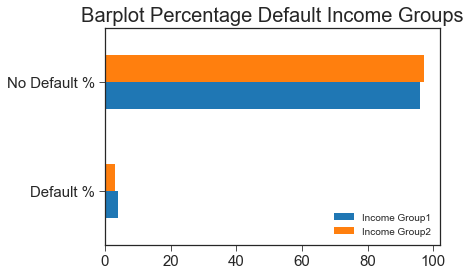

In [79]:
t = pd.concat([g1,g2] , axis=1).loc[['Default %','No Default %']].plot.barh(fontsize=15)
tt = t.set_title('Barplot Percentage Default Income Groups')
t.title.set_size(20)

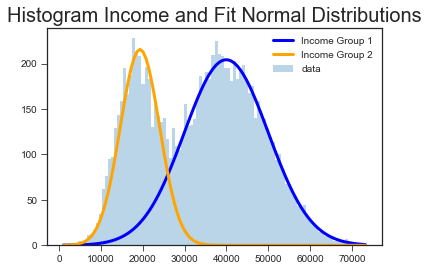

In [80]:
y,x,_= plt.hist(cc_data['income'],100,alpha=.3,label='data')

x=(x[1:]+ x[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*norm.pdf(x, loc=mu, scale=sigma)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1) + gauss(x,mu2,sigma2,A2)

expected=(18000,1000,1,39000,5000,1)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=np.sqrt(np.diag(cov))
plt.plot(x,gauss(x,params[3], params[4], params[5]),color='blue',lw=3,label='Income Group 1')
plt.plot(x,gauss(x,params[0]+1450, params[1]+150, params[2]+400000),color='orange',lw=3,label='Income Group 2')
plt.title('Histogram Income and Fit Normal Distributions').set_size(20)
t = plt.legend()

In [81]:
cc_data['nv1'] = norm.pdf(cc_data['income'], loc=params[0], scale=params[1])
cc_data['nv2'] = norm.pdf(cc_data['income'], loc=params[3], scale=params[4])
cc_data['income_group'] = np.where(cc_data['nv1'] >= cc_data['nv2'], 0, 1)
cc_data['income_group'] = cc_data['income_group'].astype('int')
cc_data = cc_data.drop(columns=['nv1','nv2'])
cc_data = cc_data.sort_index(axis=1)
cc_data.head()

,balance,balance_lt_1_eur,balance_scaled,default,default_encoded,income,income_group,income_scaled,student,student_encoded
1,729.526495,0,0.274845,No,0,44361.62507,1,0.598905,No,0
2,817.180407,0,0.307868,No,0,12106.13470,0,0.155727,Yes,1
3,1073.549164,0,0.404453,No,0,31767.13895,1,0.425862,No,0
4,529.250605,0,0.199392,No,0,35704.49394,1,0.479959,No,0
5,785.655883,0,0.295991,No,0,38463.49588,1,0.517867,No,0


In [82]:
cc_data.dtypes

balance              float64
balance_lt_1_eur       int64
balance_scaled       float64
default             category
default_encoded        int64
income               float64
income_group           int64
income_scaled        float64
student             category
student_encoded        int64
dtype: object

## Further Explore Predictive Value of Variables

In [83]:
# Plot the confusion matrix corresponding to a model
def plot_confusion_matrix(y_label, y_pred, model_name, xlabels, ylabels, ax
                          , column=None, additional_file_label='', save=True):
    matrix = confusion_matrix(y_label, y_pred)
    plot_confusion_matrix_directly(matrix, model_name, xlabels, ylabels, ax=ax
                                   , column=column, additional_file_label=additional_file_label,
                                   save=save)


# Plot a given confusion matrix
def plot_confusion_matrix_directly(matrix, model_name, xlabels, ylabels, ax
                                   , column=None, additional_file_label='', save=True):
    conf_perc = 100.0 * matrix / sum(sum(matrix))
    conf_text = pd.DataFrame(matrix.astype(str)) + '\n' + np.round(conf_perc,
                                                                   2).astype(str) + '%'
    if column:
        plt.title('Confusion Matrix (' + column + ', ' + model_name + ')',
                  fontsize=14, y=1.03)
    else:
        ax.set_title('Confusion Matrix (' + model_name + ')', fontsize=14, y=1.03)

    ax = sns.heatmap(
        matrix, annot=conf_text, fmt="s", cmap="YlGnBu", cbar=False, ax=ax
        , annot_kws={'size': 20, 'linespacing': 1.5})
    ax.set_xticklabels(xlabels, ha='center', fontsize=14)
    ax.set_yticklabels(ylabels, va='center', fontsize=14)
    if save:
        if column:
            filename = 'confusion_matrix_' + model_name.replace(' ',
                                                                '_') + '_' + column + additional_file_label \
                       + IMG_EXT
        else:
            filename = 'confusion_matrix_' + model_name.replace(' ',
                                                                '_') + additional_file_label + IMG_EXT
        plt.savefig(os.path.join(IMGDIR, filename), bbox_inches='tight')

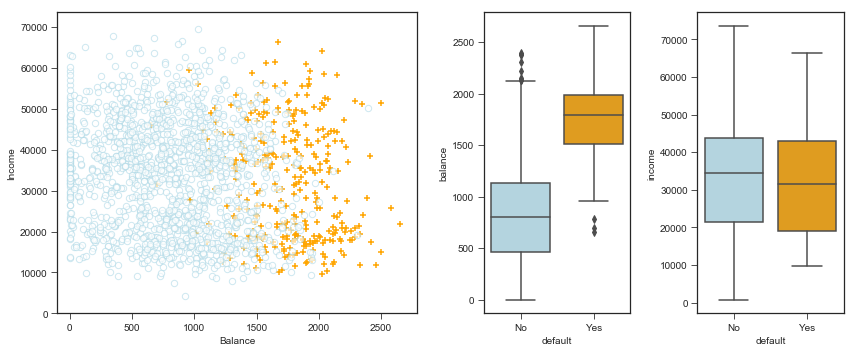

In [84]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = cc_data[cc_data.default_encoded == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = cc_data[cc_data.default_encoded == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=cc_data, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=cc_data, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

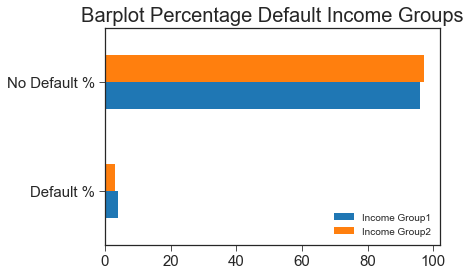

In [104]:
t = pd.concat([g1,g2] , axis=1).loc[['Default %','No Default %']].plot.barh(fontsize=15)
tt = t.set_title('Barplot Percentage Default Income Groups')
t.title.set_size(20)

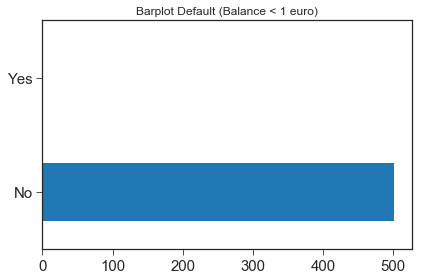

In [108]:
cc_data.loc[cc_data.balance < 1, :].default.value_counts().plot.barh(fontsize=15, title='Barplot Default (Balance < 1 euro)')
# plt.set_title_size(13)
plt.tight_layout()

In [85]:
## ADD STUDENT Vs DEFAULT
## Maybe all summary?

# CRISP-DM -- Modeling - 25% Time
## Creating Classification Model

In [113]:
X = cc_data.loc[:,['student_encoded','balance_scaled','income_scaled','balance_lt_1_eur', 'income_group']]
y = cc_data.default_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [114]:
clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [115]:
print(clf.coef_)
#bar plot - kleur negatief positief

[[-0.57648284 10.86145832  0.19811158 -0.0656461  -0.3868877 ]]


In [116]:
xclas = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, min_samples_leaf=10) 
xclas.fit(X_train, y_train)  

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, min_samples_leaf=10, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

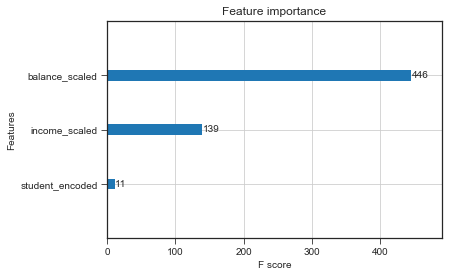

In [117]:
t = plot_importance(xclas)

# CRISP-DM -- Evaluation - 15% Time

In [91]:
pd.DataFrame(y_test.value_counts())

,default_encoded
0,3865
1,135


In [119]:
pproba_lgr_train = pd.DataFrame(clf.predict_proba(X_train))
pproba_xg_train = pd.DataFrame(xclas.predict_proba(X_train))

def compute_clf_tresh(pproba_df, y_t):
    threshold_list = [0.01, 0.02, 0.03, 0.04, 0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    y_df_scores = pd.DataFrame([], columns=['sensitivity','precision', 'weighted sensitivity and precision'
                                            ,'specificity','sensitivity + specificity'
                                            ,'avg_costs','tt_costs'])
    for i in threshold_list:
        y_df_pred_t = pproba_df.iloc[:,1].apply(lambda x: 1 if x>i else 0)
        tn, fp, fn, tp = confusion_matrix(y_t, y_df_pred_t).ravel()
        ttl = tn + fp + fn + tp
        y_df_scores.at[i,'sensitivity'] = sensitivity = recall_score(y_t, y_df_pred_t)
        y_df_scores.at[i,'precision'] = precision = precision_score(y_t, y_df_pred_t)
        w = 0.3
        y_df_scores.at[i,'weighted sensitivity and precision'] = w * precision + (1-w) * sensitivity
        y_df_scores.at[i,'specificity'] = specificity = tn / (tn+fp)
        y_df_scores.at[i,'sensitivity + specificity'] = specificity + sensitivity
        y_df_scores.at[i,'avg_costs'] = 785 * (tp/ttl) - 50 * (fp/ttl) + 0 * (fn/ttl) + 0 * (tn/ttl)
        y_df_scores.at[i,'tt_costs'] = 785 * tp - 50 * fp + 0 * fn + 0 * tn
    return y_df_scores
        
y_lgr_scores = compute_clf_tresh(pproba_lgr_train, y_train)
y_xg_scores = compute_clf_tresh(pproba_xg_train, y_train)

/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Nx/anaconda/e

In [127]:
# y_lgr_scores
y_xg_scores.sort_values('avg_costs', ascending=False)

,sensitivity,precision,weighted sensitivity and precision,specificity,sensitivity + specificity,avg_costs,tt_costs
0.05,0.89899,0.264487,0.708639,0.914685,1.81367,19.1633,114980
0.10,0.868687,0.296552,0.697046,0.929679,1.79837,19.1033,114620
0.04,0.959596,0.197505,0.730969,0.866942,1.82654,18.425,110550
0.03,0.959596,0.175439,0.724349,0.846088,1.80568,17.4167,104500
0.02,0.959596,0.171326,0.723115,0.841606,1.8012,17.2,103200
0.15,0.691919,0.433544,0.614407,0.969149,1.66107,16.4325,98595
0.20,0.651515,0.488636,0.602652,0.976732,1.62825,15.7525,94515
0.25,0.580808,0.569307,0.577358,0.985005,1.56581,14.3208,85925
0.30,0.530303,0.677419,0.574438,0.991382,1.52169,13.3208,79925
0.35,0.525253,0.675325,0.570274,0.991382,1.51663,13.19,79140


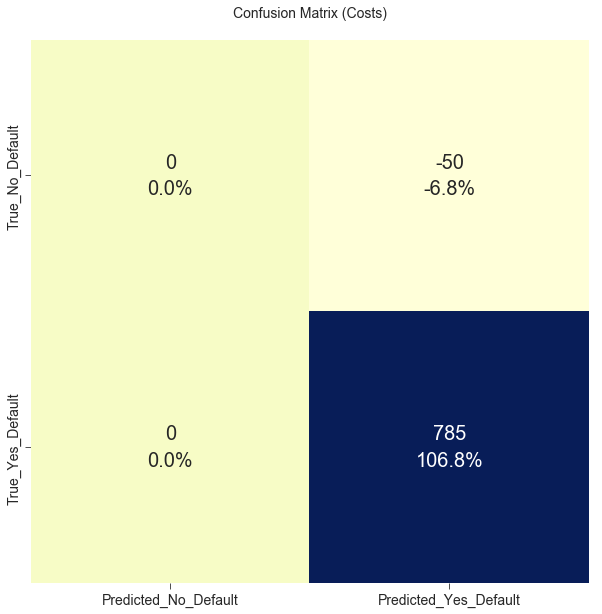

In [121]:
fig, axes = plt.subplots(1,1,figsize=(10,10))
#Todo TEXT
plot_confusion_matrix_directly(np.array([[0,-50],[0,835-50]]), 'Costs', ['Predicted_No_Default','Predicted_Yes_Default']
                               , ['True_No_Default','True_Yes_Default'], ax=axes, save=False)

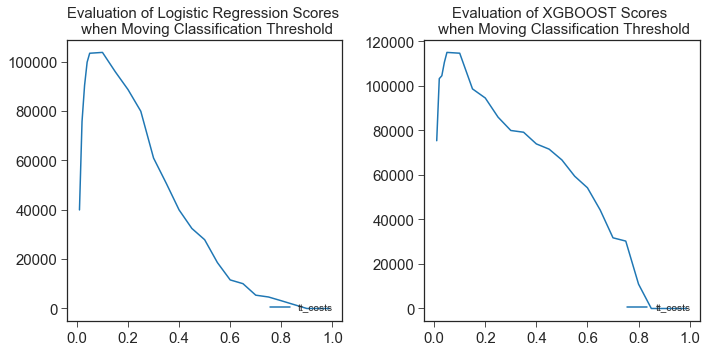

In [143]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
t = y_lgr_scores['tt_costs'].plot(ax = axes[0])
tt = t.set_title('Evaluation of Logistic Regression Scores \n when Moving Classification Threshold').set_size(15)
t.tick_params(labelsize=15)
tt = t.legend(loc='lower right')
t = y_xg_scores['tt_costs'].plot(ax = axes[1])
tt = t.set_title('Evaluation of XGBOOST Scores \n when Moving Classification Threshold').set_size(15)
t.tick_params(labelsize=15)
tt = t.legend(loc='lower right')
plt.tight_layout()

In [128]:
pproba_lgr_test = pd.DataFrame(clf.predict_proba(X_test))
pproba_xg_test = pd.DataFrame(xclas.predict_proba(X_test))
y_lgr_pred_test = pproba_lgr_test.iloc[:,1].apply(lambda x: 1 if x> 0.05 else 0)
y_xg_pred_test = pproba_xg_test.iloc[:,1].apply(lambda x: 1 if x> 0.05 else 0)

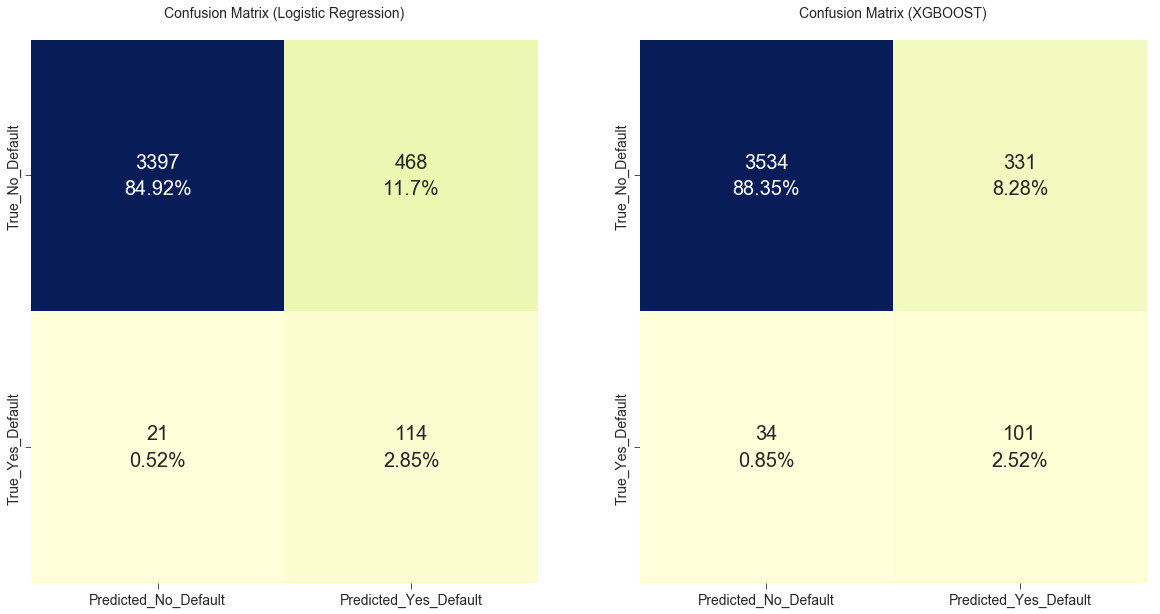

In [129]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
plot_confusion_matrix(y_test, y_lgr_pred_test, 'Logistic Regression', ['Predicted_No_Default','Predicted_Yes_Default']
                      , ['True_No_Default','True_Yes_Default'], ax=axes[0], save=False)
plot_confusion_matrix(y_test, y_xg_pred_test, 'XGBOOST', ['Predicted_No_Default','Predicted_Yes_Default']
                      , ['True_No_Default','True_Yes_Default'], ax=axes[1], save=False)

In [130]:
# print(f1_score(y_test, y_lgr_pred_test), precision_score(y_test, y_lgr_pred))
# print(f1_score(y_test, y_xg_pred_test), precision_score(y_test, y_xg_pred))

In [131]:
##TODO CHECK SORTING
##ADD Viz Profit Curve

def precision_top(y_true, y_proba, pct=2):
    #bereken de precisie van top n beste voorspellingen
    # y_proba and y_true are lists
        
    proba = pd.Series(y_proba).reset_index(drop=True)
    true = pd.Series(y_true).reset_index(drop=True)
        
    n = int(y_true.shape[0]*pct/100)
    rows = proba.sort_values().iloc[-1*n:].index
    selected = true.loc[rows]
    return selected.mean()


def plot_precisie(y_proba, y_true, label, color='C1', fmin=0.4, fmax=10, fstap=10):
    fmin = math.log10(fmin)
    fmax = math.log10(fmax)
    
    fracties = []#[0.05, 0.1, 0.2, 0.5, 1, 2, 3, 5, 7, 10]
    precisies = []
    precisies_totaal = []
    precisies_verhuis = []
    precisies_oversluit = []
    
    factor_totaal = []
    factor_verhuis = []
    factor_oversluit = []
    

    for i in range(fstap+1):
        f = pow(10, fmin + (fmax - fmin) / fstap * i )
        fracties.append(f)
        precisies.append(precision_top(y_proba, y_true, f))
    
    fig, ax_v = plt.subplots()
    #fig.subplots_adjust(left=0.25)
    ax_vf = ax_v.twinx()
    ax_vf.spines["left"].set_position(("axes", -0.15)) 
    ax_vf.spines["left"].set_visible(True)
    ax_vf.yaxis.set_label_position('left')
    ax_vf.yaxis.set_ticks_position('left')
    
    p_v, = ax_v.plot(fracties, precisies, label=label, color=color)
    mn, mx = ax_v.get_ylim()
    ax_vf.set_ylim(mn/y_true.mean(), mx/y_true.mean())
    ax_vf.set_ylabel('Factor verbetering')
    ax_v.set_ylabel('Precisie')
    ax_v.set_xlabel('Percentage klanten in campagne')
    
    ax_v.yaxis.label.set_color(color)
    ax_vf.yaxis.label.set_color(color)
    tkw = dict(size=4, width=1.5, colors=color)
    ax_v.tick_params(axis='y',**tkw)# colors=p_v.get_color(), )
    ax_vf.tick_params(axis='y', **tkw)#colors=p_v.get_color(), **tkw)
    
    ax_v.legend(loc='upper right')#bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
    
    plt.locator_params(numticks=6)
    
    plt.show()

/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


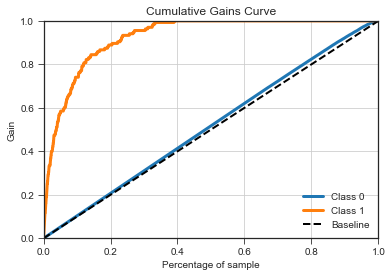

In [132]:
skplt.metrics.plot_cumulative_gain(y_true=y_test, y_probas=pproba_lgr_test)

/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


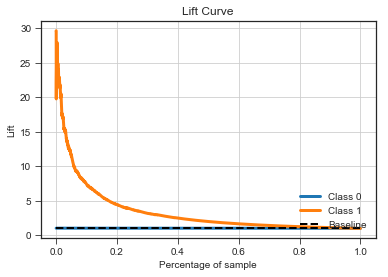

In [133]:
skplt.metrics.plot_lift_curve(y_true=y_test, y_probas=pproba_lgr_test)

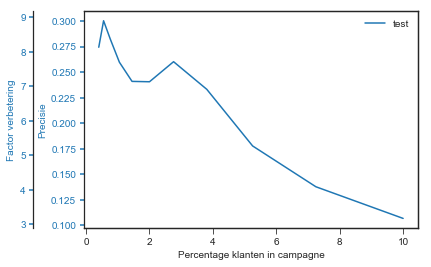

In [134]:
#TODO use skiplot
plot_precisie(pproba_lgr_test.loc[:,1], y_test, 'test', color='C0')

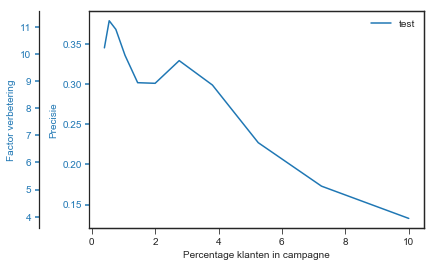

In [135]:
plot_precisie(pproba_xg_test.loc[:,1], y_test, 'test', color='C0')

In [138]:
sscr_lgr = pd.DataFrame(list(zip(y_test, pproba_xg_test.loc[:,1])), columns=['true_label','prob_pred']) \
    .sort_values(by=['prob_pred'], ascending=False).reset_index(drop=True)

In [139]:
for i in range(0,sscr_lgr.shape[0],1):
    tn, fp, fn, tp  = confusion_matrix(sscr_lgr.true_label, sscr_lgr.prob_pred > sscr_lgr.loc[i,'prob_pred']).ravel()
    ttl = tn + fp + fn + tp
    sscr_lgr.loc[i,'tn'] = tn
    sscr_lgr.loc[i,'fp'] = fp
    sscr_lgr.loc[i,'fn'] = fn
    sscr_lgr.loc[i,'tp'] = tp
    sscr_lgr.loc[i,'avg_costs'] = 785 * (tp/ttl) - 50 * (fp/ttl) + 0 * (fn/ttl) + 0 * (tn/ttl)

In [140]:
sscr_lgr['cum_costs'] = sscr_lgr.avg_costs.cumsum()
sscr_lgr['cum_costs'].head()

0    0.0000
1    0.0000
2    0.0000
3    0.3800
4    0.7475
Name: cum_costs, dtype: float64

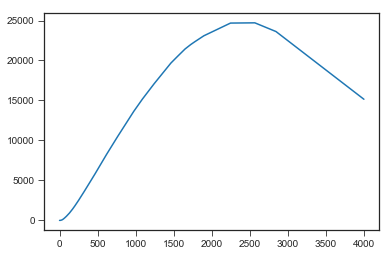

In [141]:
sscr_lgr['cum_costs'].plot()

# CRISP-DM -- Deployment